In [21]:
import random
def generateGraph(nodes, chance_for_zero):
    net = {}
    mat = [[0 for _ in range(nodes)] for _ in range(nodes)]
    distMat = [[0 for _ in range(nodes)] for _ in range(nodes)]
    for i in range(nodes):
        for j in range(nodes):
            if i == j:
                mat[i][j] = 0
                distMat[i][j] = 0
            else:
                p = random.random()
                if p > chance_for_zero:
                    mat[i][j] = random.randint(1, 1000)
                    # mat[i][j] = 1
                    distMat[i][j] = mat[i][j]
                else:
                    mat[i][j] = 0
                    distMat[i][j] = 2000
    net['noNodes'] = nodes
    net['noEdges'] = nodes * (nodes - 1)
    net['mat'] = mat
    net['distMat'] = distMat
    return net

In [22]:
import networkx as nx
import numpy as np
# 
def readFromGML(filePath):
    G = nx.read_gml(filePath, label='id')
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

    adj_list = G.adj
    #print(adj_list)
    net = {}
    net['adjList'] = adj_list
    net['noNodes'] = G.number_of_nodes()
    net['noEdges'] = G.number_of_edges()
    net['nodes'] = list(G.nodes())
    net['edges'] = G.edges()
    A = nx.to_numpy_matrix(G)
    net['mat'] = A
    

    deg = dict(G.degree())
    net['degrees'] = np.array(list(deg.values()))
    
    return net

#readFromGML('data\\real\\krebs\\krebs.gml')

In [23]:
import matplotlib.pyplot as plt 
import warnings 

# plot a network 
def plotNetwork(network, communities, titleGML, paths):
    np.random.seed(123) #to freeze the graph's view (networks uses a random view)
    #for chr in paths:
    A=np.matrix(network["mat"])
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)  # compute graph layout
    plt.figure(figsize=(8, 8))  # image is 8 x 8 inches 
    labels = {i: i for i in G.nodes()}

    edge_colors = []
    for edge in network['edges']:
        if edge in paths:
            edge_colors.append(1)
        else:
            edge_colors.append(0)

    if titleGML == 'netscience.gml' or titleGML == 'cora.gml':
        # nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.RdYlBu, node_color = communities)
        nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.RdYlBu)
        # nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color=edge_colors)
        nx.draw_networkx_labels(G, pos, labels, font_weight='bold')
    else:
        # nx.draw_networkx_nodes(G, pos, node_size=80, cmap=plt.cm.RdYlBu, node_color = communities)
        nx.draw_networkx_nodes(G, pos, node_size=80, cmap=plt.cm.RdYlBu)
        # nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color={chr.repres:'r'})
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=edge_colors)
        nx.draw_networkx_labels(G, pos, labels, font_weight='bold')
    plt.title(titleGML)
    plt.show(G)

### Chromosome definition
<strong>Initialization</strong> - Path from SOURCE to DESTINATION where each edge (not from the whole graph) is chosen once randomly <br/>
<strong>Selection</strong> - First best 2 individuals <br/>
<strong>Crossover and Mutation</strong> - Choosing a <u>intersection</u> at random and the 2 offsprings will take half path of one parent and the other half from the other parent <br/>
(<u>Intersections</u> = nodes met in both individuals in the path) <br/>
<strong>Replacement</strong> - If more fit, will replace the worst in that generation<br/>
<strong>Termination condition</strong> - Predefined number of iterations<br/>
<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.712.8445&rep=rep1&type=pdf">credit

In [24]:
import random
class Chromosome:
    def __init__(self, problParam):
        self.__problParam = problParam
        self.__fitness = 0.0
        self.__repres = []


    @property
    def fitness(self):
        return self.__fitness
    
    @property
    def repres(self):
        return self.__repres
    
    @fitness.setter
    def fitness(self, fit = 0.0):
        self.__fitness = fit
    
    @repres.setter
    def repres(self, l = []):
        self.__repres = l
        
    def initPath(self):
        adjList = self.__problParam['network']['adjList']
        source = self.__problParam['source']
        destination = self.__problParam['destination']

        # used nodes
        used_nodes = set()
        # used edges, we need to choose an edge only once
        used_edges = set()
        # nodes which lead to dead-ends
        waste_nodes = set()
        k = True
        while k == True or source != destination:
            print(self.__repres)
            k = False
            # getting the neighbors of source as a dictionary of {key=node, value=weight}
            neighbors_dict = adjList[source]
            
            #checking if there's any left edges from this node to build the path, if not we go 1 step back
            noUsedEdges = 0
            noUsedNodes = 0
            neighbors = list(neighbors_dict.keys())
            for neighbor in neighbors:
                if neighbor in used_nodes:
                    noUsedNodes += 1
                if (source, neighbor) in used_edges or (neighbor, source) in used_edges:
                    noUsedEdges += 1
            

            if noUsedEdges == len(neighbors) or noUsedNodes == len(neighbors):
                #print('alo')
                waste_nodes.add(source)
                parent, _, _ = self.__repres.pop()
                source = parent
            #-----------------
            
            # random neighbor and its weight
            random_neighbor = random.choice(neighbors)
            weight = neighbors_dict[random_neighbor]
            #* verifying it's not a path we already chose
            #print(f'trying edge {source}, {random_neighbor}')
            # print(f'current repres: {self.__repres}')
            # print(f'used nodes: {used_nodes}')
            # print(f'source node {source}')
            # print(f'at neighbor{random_neighbor}')
            if random_neighbor not in used_nodes and random_neighbor not in waste_nodes and(source, random_neighbor) not in used_edges and (random_neighbor, source) not in used_edges:
                #print('valid')
                used_nodes.add(random_neighbor)
                self.__repres.append((source, random_neighbor, 1))
                used_edges.add((source, random_neighbor))
                source = random_neighbor
            else:
                #tried an already chosen edge
                #assume there will always be path to destination => no invalids chromosomes
                continue
                

    def crossover_mutation(self, c):
        #selecting a random intersection
        repres1 = self.__repres
        repres2 = c.repres
        #print(f'repres1: {repres1}, repres2: {repres2}')
        intersections = list(set(repres1).intersection(repres2))
        #print('lol1')
        if len(intersections) == 0:
            return self, c
        random_intersection = random.choice(intersections)
        #print('lol2')
        #getting the index of where the intersection is found in the parents
        index1 = repres1.index(random_intersection)
        #print('lol3')
        index2 = repres2.index(random_intersection)
        #print('lol4')
        #creating offspring
        offspring1 = Chromosome(self.__problParam)
        offspring2 = Chromosome(self.__problParam)
        offspring1.repres = repres1[:index1] + repres2[index2:]
        offspring2.repres = repres2[:index2] + repres1[index1:]

        offspring1.fitness = self.__problParam['function'](offspring1.repres, self.__problParam['network']['noNodes'])
        offspring2.fitness = self.__problParam['function'](offspring2.repres, self.__problParam['network']['noNodes'])
        


        return offspring1, offspring2

### Fitness function
Sum of all weights on the path, where a path entry is represented by {u, v, w}, meaning there is an edge between u and v of weight w

In [25]:
def sumWeights(path, V):
    sum = 0
    path_nodes = set()
    for u, v, weight in path:
        path_nodes.add(u)
        path_nodes.add(v)
       # print(f'weight: {weight}')
        sum += 1
    return sum

### Genetic algorithm
Each crossover&mutation update the population

In [26]:
import heapq
class GA:
    def __init__(self, problParam = None):
        #self.__param = param
        self.__problParam = problParam
        self.__population = []

    def inititialization(self):
        for chrCount in range(self.__problParam['popSize']):
            print('initializare - at chr: ', chrCount)
            c = Chromosome(self.__problParam)
            c.initPath()
            print('passed init path')
            self.__population.append(c)

    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.repres, self.__problParam['network']['noNodes'])

    def nextGeneration(self):
        fitness = lambda x: x.fitness
        #select the best 2 individuals
        best_entries = heapq.nsmallest(2, self.__population, key=fitness)
        p1 = best_entries[0]
        p2 = best_entries[1]
        #generating their offspring
        offspring1, offspring2 = p1.crossover_mutation(p2)

        #getting the 2 least fit individuals
        worst_indices = sorted(range(len(self.__population)), key=lambda i:self.__population[i].fitness, reverse=True)[:2]
        replaced1 = False
        replaced2 = False
        #we either replace first, or second offspring, if they are more fit
        if offspring1.fitness < self.__population[worst_indices[0]].fitness:
            #we replaced first offspring
            self.__population[worst_indices[0]] = offspring1
            replaced1 = True
        elif offspring2.fitness < self.__population[worst_indices[0]].fitness:
            #we replaced second offspring
            self.__population[worst_indices[0]] = offspring2
            replaced2 = True

        #right now, either one of the offsprings has been replaced, we evaluate the other with the 2nd worst
        if replaced1 == False and offspring1.fitness < self.__population[worst_indices[1]].fitness:
            #we didnt replace first offspring with the worst
            self.__population[worst_indices[1]] = offspring1
            replaced1 = True
        elif replaced2 == False and offspring2.fitness < self.__population[worst_indices[1]].fitness:
            #we didnt replace second offspring with the worst
            self.__population[worst_indices[1]] = offspring2
            replaced2 = True
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if c.fitness < best.fitness:
                best = c
        best_list = []
        for c in self.__population:
            if c.fitness == best.fitness:
                #print('found chr with best fitness')
                best_list.append(c)
        return best_list


Applying Dijsktra on the graph. We will compare results of GA to Dijkstra

In [27]:
import heapq
def Dijkstra(V, adjList, source, destination):
    seen = set()
    dist = [1e9] * (V)
    dist[source] = 0
    heap = []
    parent = [-1] * (V)
    heapq.heappush(heap, (source, dist[source]))

    while len(heap) > 0:
        node, weight = heapq.heappop(heap)
        seen.add(node) 

        for neighbor in adjList[node].keys():
            if neighbor not in seen:
                d = weight + 1
                if d < dist[neighbor]:
                    parent[neighbor] = node
                    dist[neighbor] = d
                    heapq.heappush(heap, (neighbor, d))
    #building the list of edges in the shortest path from destination to source
    edges_list = []
    node = destination
    while parent[node] != -1:
        edges_list.append((node, parent[node]))
        node = parent[node]
    return edges_list

C:\Users\Stefan YKM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\drawing\nx_pylab.py:462: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


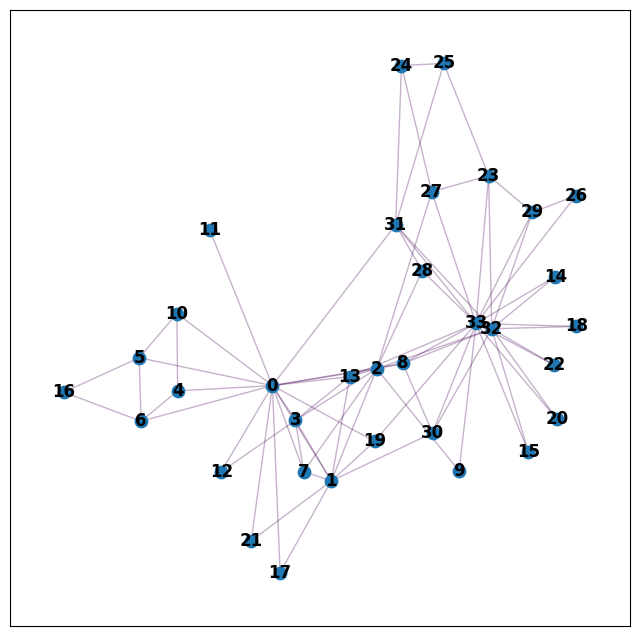

initializare - at chr:  0
[]
[(14, 32, 1)]
[(14, 32, 1), (32, 29, 1)]
[(14, 32, 1), (32, 29, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27, 23, 1)]
[(14, 32, 1), (32, 29, 1), (29, 33, 1), (33, 27, 1), (27,

IntProgress(value=1, max=30, min=1)

source = 14, destination = 14
fitness: 3, repres: [(14, 33, 1), (33, 32, 1), (32, 14, 1)]
nodes contained: 3


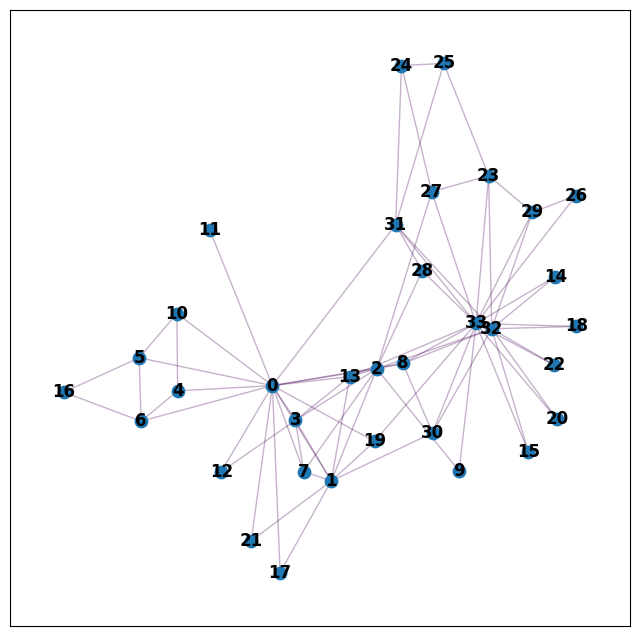

fitness: 3, repres: [(14, 32, 1), (32, 33, 1), (33, 14, 1)]
nodes contained: 3


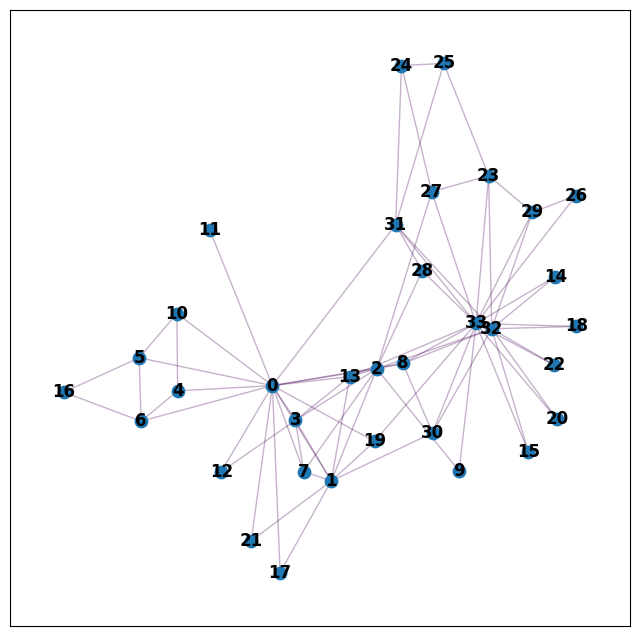

: 

In [28]:
import ipywidgets as widgets
import time
def applyGA(network, source, destination, iterations):
    problParam = {'popSize': 50, 'noGen': 50, 'network': network, 'source': source, 'destination': destination, 'function': sumWeights}
    #print('constructor')
    ga = GA(problParam)
    #print('initializare')
    ga.inititialization()
    #print('evaluare')
    ga.evaluation()

    progressBar = widgets.IntProgress(min=1, max=iterations)
    display(progressBar)
    for _ in range(iterations):
        ga.nextGeneration()
        progressBar.value += 1
        time.sleep(0.01)

    best_list = ga.bestChromosome()
    unique_paths = []
    seen_paths = set()
    for path in best_list:
        path_repr = tuple(path.repres)
        if path_repr not in seen_paths:
            unique_paths.append(path)
            seen_paths.add(path_repr)
    print(f'source = {source}, destination = {destination}')
    for path in unique_paths:
        print(f'fitness: {path.fitness}, repres: {path.repres}')
        print(f'nodes contained: {nodesContained(path.repres)}')
        plotNetwork(network, titleGML='', communities=[0,0,0,0], paths=path.repres)
    
    dijkstra_edges = Dijkstra(network['noNodes'], network['adjList'], source, destination)
    #print(dijkstra_edges)
    #print(len(dijkstra_edges))

def nodesContained(repres):
    nodes = set()
    for u, v, _ in repres:
        nodes.add(u)
        nodes.add(v)
    return len(nodes)

# network = readFromGML('data\\real\\krebs\\krebs.gml')
network = readFromGML('data\\real\\karate\\karate.gml')
# network = generateGraph(nodes=10, chance_for_zero=0.5)
#print(network['nodes'])
plotNetwork(network, titleGML='', communities=[0,0,0,0], paths=[])
applyGA(network, source = 14, destination =14, iterations=30)